In [1]:
DATA_PATH = '../data/processed/01_preprocessed_df.pkl'
EXPORT_PATH = '../data/processed/02_cleaned_df.pkl'

ROLE_COLS  = ['DevType']
TECH_COLS  = ['LanguageHaveWorkedWith',
              'DatabaseHaveWorkedWith',
              'WebframeHaveWorkedWith',
              'MiscTechHaveWorkedWith',
              'ToolsTechHaveWorkedWith']

EXCLUDE_ROLES = ['Other (please specify):',
                 'Student',
                 'Designer',
                 'Educator',
                 'Marketing or sales professional',
                 'Engineering manager',
                 'Senior Executive (C-Suite, VP, etc.)',
                 'Product manager',
                 'Engineer, site reliability']

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sys

sys.path.append('../scripts')
from preprocessing import one_hot_encode


### Initialize and preprocess

In [5]:
# Read and preprocess
processed_df = pd.read_pickle(DATA_PATH)
ohe_df = one_hot_encode(processed_df, ROLE_COLS + TECH_COLS)

In [6]:
# Initialize exclusion list
exclude_masks = []

## Build filtering masks

### 1. Filter on number of roles specified

In [7]:
# Calculate
freq_roles = ohe_df[ROLE_COLS].sum(axis=1)
freq_roles.value_counts().sort_index()

0     16955
1     26917
2     13750
3      9926
4      6237
5      3683
6      2251
7      1385
8       840
9       535
10      315
11      230
12      142
13       85
14       43
15       36
16       28
17       15
18        9
19       11
20        1
21        6
22        2
23        7
24       18
25       12
dtype: int64

In [8]:
# Create and save exclusion mask
N_ROLES_RANGE = [1,3]

exclude_nroles = (freq_roles < N_ROLES_RANGE[0]) | (freq_roles > N_ROLES_RANGE[1])
exclude_nroles.name = 'n_roles'

exclude_masks.append(exclude_nroles)

### 2. Filter on number of techs specified

In [9]:
# Calculate
freq_tech = ohe_df[TECH_COLS].sum(axis=1)
freq_tech.value_counts().sort_index()

0      717
1      801
2     1414
3     2023
4     2694
      ... 
93       1
94       2
95       2
96       2
97      15
Length: 86, dtype: int64

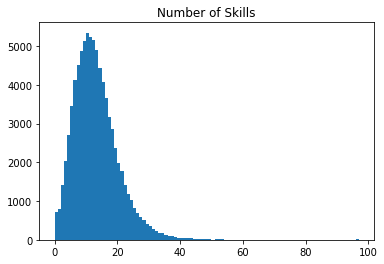

In [10]:
# plot
plt.hist(freq_tech, freq_tech.max())
plt.title('Number of Skills')
plt.show()

In [11]:
# Create and save exclusion mask
N_TECH_RANGE = [2,15]

exclude_ntech = (freq_tech < N_TECH_RANGE[0]) | (freq_tech > N_TECH_RANGE[1])
exclude_ntech.name = 'n_tech'

exclude_masks.append(exclude_ntech)

### 3. Filter on employment

In [12]:
# Calculate
processed_df['Employment'].value_counts()

Employed full-time                                      53584
Student, full-time                                      11781
Independent contractor, freelancer, or self-employed     8041
Not employed, but looking for work                       2961
Employed part-time                                       2461
Student, part-time                                       2051
Not employed, and not looking for work                   1228
I prefer not to say                                       890
Retired                                                   326
Name: Employment, dtype: int64

In [13]:
# Create and save exclusion mask
KEEP_EMPLOYMENT = ['Employed full-time', 'Employed part-time']

exclude_employment = ~processed_df['Employment'].isin(KEEP_EMPLOYMENT)
exclude_employment.name = 'employment'

exclude_masks.append(exclude_employment)

### 4. Filter on relevant roles

In [14]:
exclude_single_roles = [[role] for role in EXCLUDE_ROLES]

In [15]:
exclude_role = processed_df['DevType'].isin(exclude_single_roles)
exclude_role.name = 'role'

exclude_masks.append(exclude_role)

_____

## Filter Dataframe

In [16]:
# Merge masks
exclude_df = pd.DataFrame(exclude_masks).T

In [17]:
# Get insights: percentages of exclusion per filter
exclude_df.sum() * 100 / len(exclude_df)

n_roles       39.365285
n_tech        31.232397
employment    32.831170
role           4.757967
dtype: float64

In [18]:
# Get insights: multiple exclusion criteria
# 36% of the data will be kept
exclude_df.sum(axis=1).value_counts() * 100 / len(exclude_df)

0    36.115006
1    28.251777
2    26.964609
3     8.668608
dtype: float64

In [19]:
# If any of the exclusion criteria occured, drop
final_exclusion_mask = exclude_df.any(axis=1)
cleaned_df = processed_df[~final_exclusion_mask].copy()

## Export

In [20]:
cleaned_df.to_pickle(EXPORT_PATH)